<h4>Meanshift</h4>

Meanshift sử dụng để theo dõi một vùng xác định trước trong một video. Ý tưởng chính của meanshift là từ khung hình tại thời điểm t, xác định vùng theo dõi trên khung hình t+1 bằng cách di chuyển tâm điểm của vùng theo dõi bắt đầu từ vị trí ở khung hình t cho đễn khi đạt được sự so khớp trong phạm vi cho phép. Các bước chính trong hoạt động của Meanshift như sau:
1. Khởi tạo: Chọn một cửa sổ (window) ban đầu để theo dõi, thường được xác định bởi người dùng hoặc một thuật toán phát hiện đối tượng. Cửa sổ này chứa vùng muốn theo dõi, thường là một hình chữ nhật bao quanh đối tượng.
2. Tính toán Histogram: Tính toán histogram của các đặc trưng (ví dụ: màu sắc) bên trong cửa sổ ban đầu. Histogram này sẽ được sử dụng làm mẫu để so sánh với các cửa sổ khác trong khung hình kế tiếp.
3. Cập nhật Vị trí Cửa sổ: Với mỗi khung hình tiếp theo trong video, cửa sổ ban đầu được di chuyển đến một vị trí mới bằng cách sử dụng Mean Shift.
Mean Shift tính toán tâm (mean) của cửa sổ hiện tại dựa trên mật độ điểm dữ liệu (các pixel có giá trị đặc trưng tương tự như mẫu ban đầu) trong cửa sổ đó. Cửa sổ sẽ được di chuyển đến vị trí của tâm mới này. Chi tiết cập nhật vị trí như sau:
<ul>
    <li>Tính toán trọng số: Mỗi pixel trong cửa sổ hiện tại được gán một trọng số dựa trên sự tương đồng của nó với mẫu ban đầu (thường dựa trên histogram).</li>
    <li>Tính toán trọng tâm (mean): Trọng tâm của các pixel được tính toán bằng cách sử dụng trọng số đã gán.</li>
    <li>Di chuyển cửa sổ: Cửa sổ được di chuyển đến vị trí trọng tâm mới và quá trình được lặp lại.</li>
4. Lặp lại: Các bước tính toán histogram và cập nhật vị trí cửa sổ được lặp lại cho mỗi khung hình trong video cho đến khi cửa sổ hội tụ (không còn di chuyển đáng kể) hoặc đạt đến một điều kiện dừng khác (ví dụ: số lượng khung hình đã được xử lý).

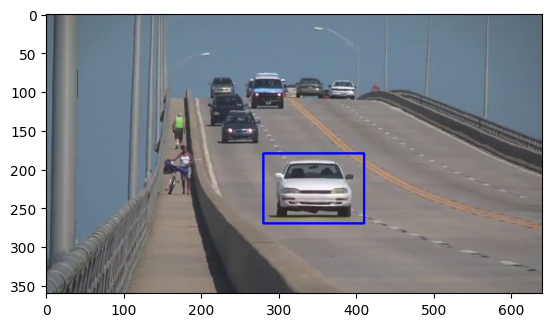

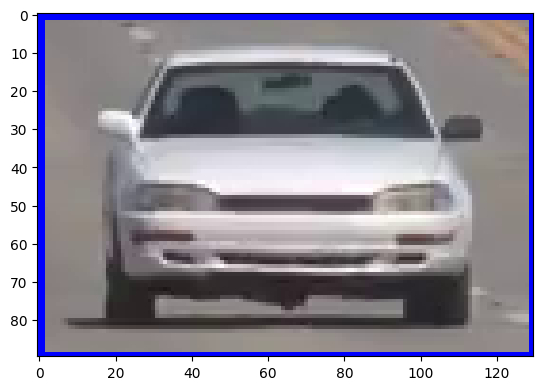

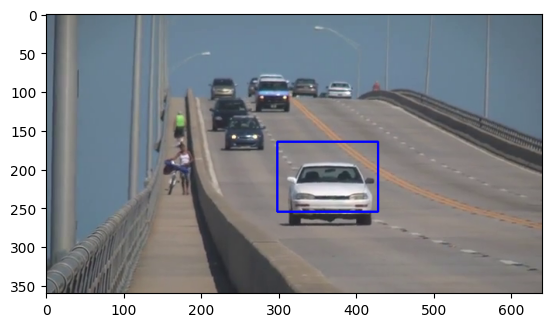

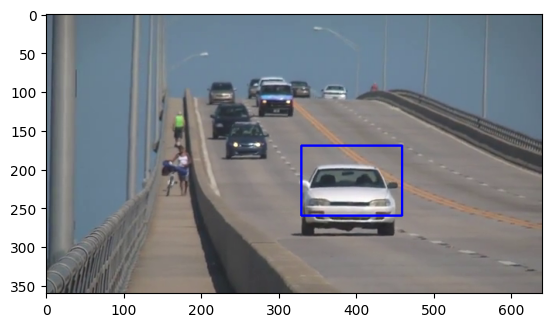

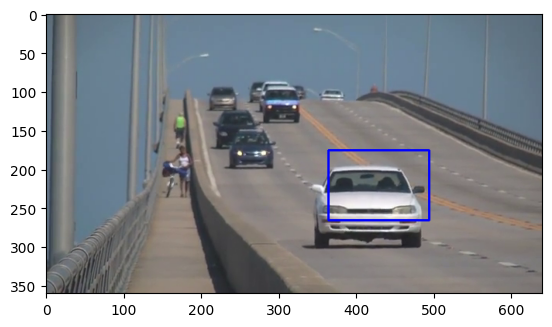

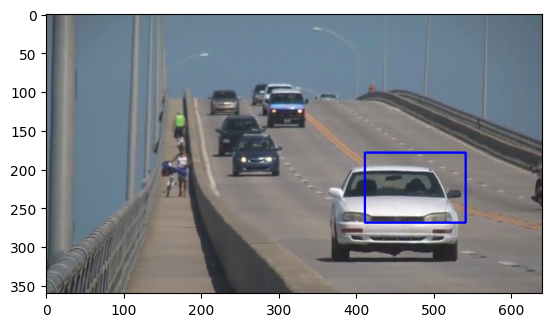

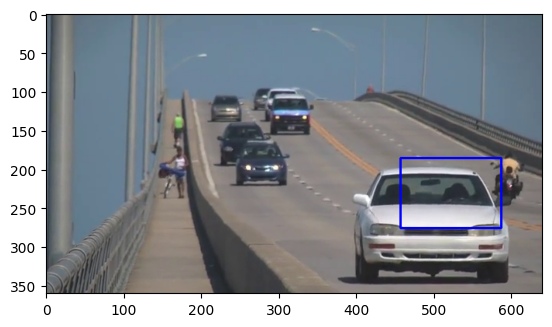

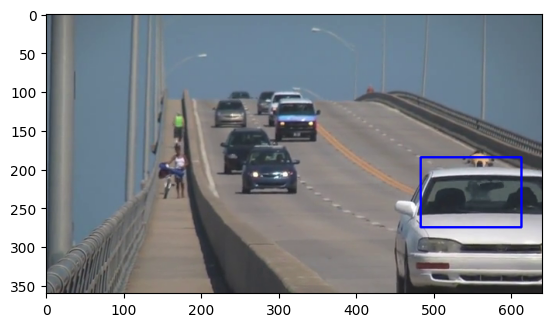

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

cap = cv2.VideoCapture('slow_traffic_small.mp4')

# Đọc khung hình đầu tiên
ret, frame = cap.read()

# khởi tạo tọa độ của vùng theo dõi 
x, y, w, h = 280, 180, 130, 90   
track_window = (x, y, w, h)
rect_frame = cv2.rectangle(frame, (x, y), (x + w, y + h), 255, 2)

# Chuyển đổi màu BGR sang RGB để hiển thị với matplotlib
plt.imshow(cv2.cvtColor(rect_frame, cv2.COLOR_BGR2RGB))
plt.show()

# Xác định ROI (Region of Interest) và tính histogram theo thang Hue (màu HSV) của vùng đó
roi = frame[y:y+h, x:x+w]
plt.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
plt.show()
hsv_roi = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
mask = cv2.inRange(hsv_roi, np.array((0., 60., 32.)), np.array((180., 255., 255.)))
roi_hist = cv2.calcHist([hsv_roi], [0], mask, [180], [0, 180])
cv2.normalize(roi_hist, roi_hist, 0, 255, cv2.NORM_MINMAX)

# Thiết lập tiêu chí kết thúc cho Meanshift ( dừng sau 10 lần lặp hoặc độ dịch là 1px)
term_crit = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1)

count_frame = 0
while count_frame <= 150:
    count_frame += 1
    ret, frame = cap.read()

    if ret:
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        dst = cv2.calcBackProject([hsv], [0], roi_hist, [0, 180], 1)

        # áp dụng meanshift để tìm tâm điểm mới
        ret, track_window = cv2.meanShift(dst, track_window, term_crit)

        # Hiển thị quá trình theo dõi 
        x, y, w, h = track_window
        img2 = cv2.rectangle(frame, (x, y), (x+w, y+h), 255, 2)
        cv2.imshow('img2', img2)

        if count_frame % 25 == 0:
            plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
            plt.show()

        k = cv2.waitKey(60) & 0xff
        if k == 27:
            break

    else:
        break

cv2.destroyAllWindows()
cap.release()


<h4>Camshift</h4>

Camshift sử dụng một phương pháp gọi là "Scale Adaptive Mean Shift" để thích ứng và điều chỉnh tự động kích thước của vùng theo dõi dựa trên các thông tin từ histogram. Đầu tiên, Camshift thực hiện Meanshift. Đến khi meanshift hội tụ, thì nó sẽ cập nhật kích thước của cửa sổ theo dõi dựa trên công thức $s = 2\sqrt{\frac{M_{00}}{256}}$, trong đó $M_{00} = \sum_{x,y}{I(x,y)}$, và cuối cùng là tính toán hướng của elip phù hợp với nó nhất.

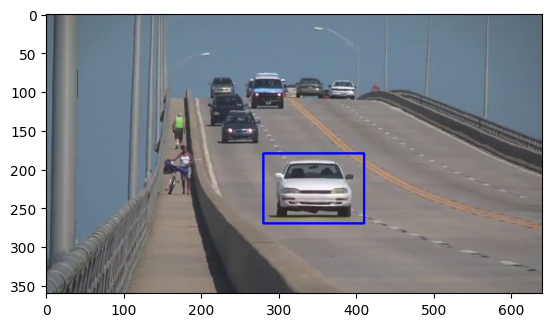

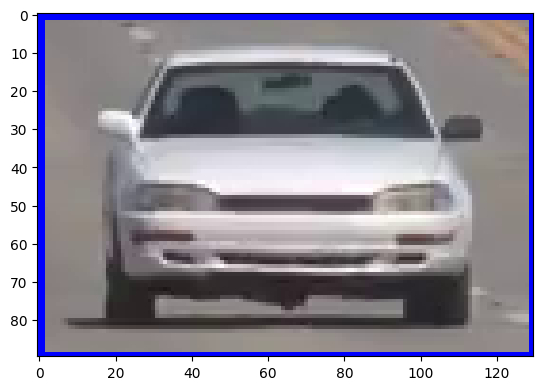

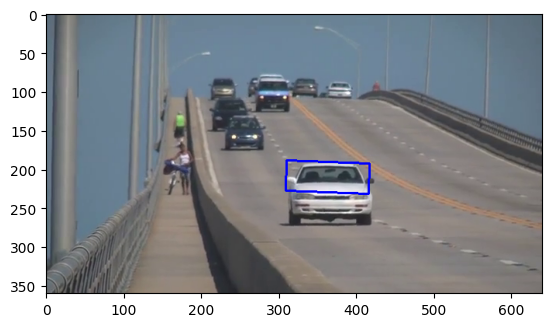

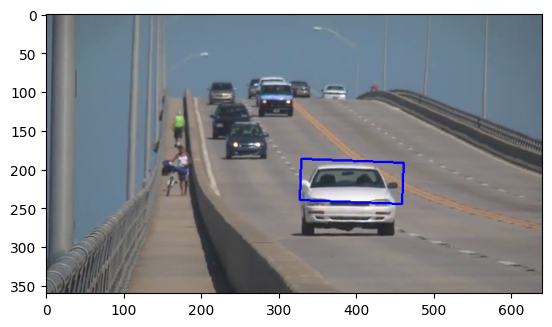

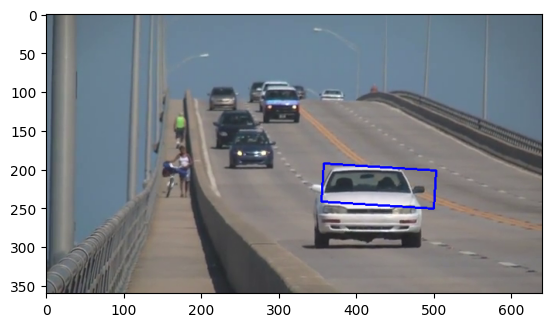

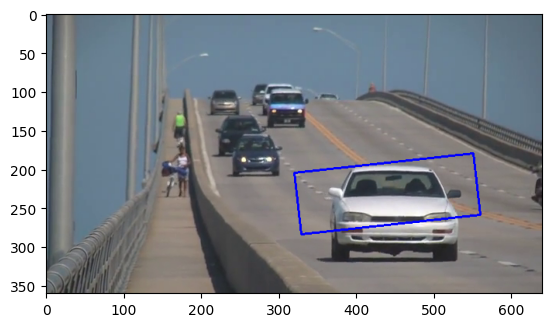

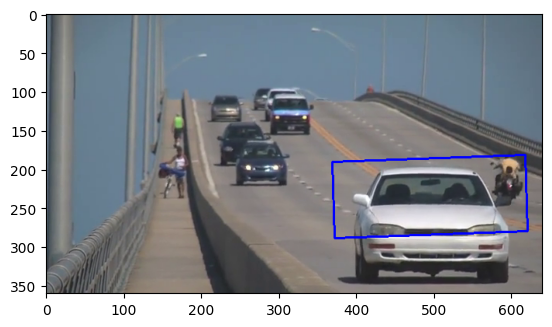

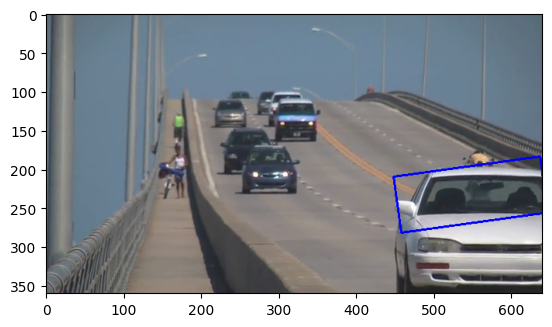

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

cap = cv2.VideoCapture('slow_traffic_small.mp4')

# Đọc khung hình đầu tiên
ret, frame = cap.read()

# khởi tạo tọa độ của vùng theo dõi 
x, y, w, h = 280, 180, 130, 90   
track_window = (x, y, w, h)
rect_frame = cv2.rectangle(frame, (x, y), (x + w, y + h), 255, 2)

# Chuyển đổi màu BGR sang RGB để hiển thị với matplotlib
plt.imshow(cv2.cvtColor(rect_frame, cv2.COLOR_BGR2RGB))
plt.show()

# Xác định ROI (Region of Interest) và tính histogram theo thang Hue (màu HSV) của vùng đó
roi = frame[y:y+h, x:x+w]
plt.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
plt.show()
hsv_roi = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
mask = cv2.inRange(hsv_roi, np.array((0., 60., 32.)), np.array((180., 255., 255.)))
roi_hist = cv2.calcHist([hsv_roi], [0], mask, [180], [0, 180])
cv2.normalize(roi_hist, roi_hist, 0, 255, cv2.NORM_MINMAX)

# Thiết lập tiêu chí kết thúc cho Meanshift ( dừng sau 10 lần lặp hoặc độ dịch là 1px)
term_crit = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1)

count_frame = 0
while count_frame <= 150:
    count_frame += 1
    ret, frame = cap.read()

    if ret:
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        dst = cv2.calcBackProject([hsv], [0], roi_hist, [0, 180], 1)

        # áp dụng meanshift để tìm tâm điểm mới
        ret, track_window = cv2.CamShift(dst, track_window, term_crit)

        # Hiển thị quá trình theo dõi 
        pts = cv2.boxPoints(ret)
        pts = np.intp(pts)
        img2 = cv2.polylines(frame,[pts],True, 255,2)
        cv2.imshow('img2',img2)

        if count_frame % 25 == 0:
            plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
            plt.show()

        k = cv2.waitKey(60) & 0xff
        if k == 27:
            break

    else:
        break

cv2.destroyAllWindows()
cap.release()
